In [1]:
import extract_hkm_cmdty
import load_futures_data
import calc_commodities_returns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pull_bbg_commodities_basis
from replicate_cmdty import generate_corr_matrix, decide_optimal_pairs

import sys

sys.path.append("..")

from settings import config

BASE_DIR = config("BASE_DIR")
DATA_DIR = config("DATA_DIR")

# Cleaning Summary: Commodities Returns

This notebook outlines the steps taken to generate an approximate replication of the commodity return series presented in He, Kelly, and Manela (2017).

## Overview

He, Kelly, and Manela constructed monthly returns for 23 commodities selected from a larger set of 31 commodities originally studied by Yang (2013). These commodities were chosen based on data availability from the Commodity Research Bureau (CRB), requiring at least 25 years of monthly returns data. He, Kelly, and Manela employed an equal-weighted portfolio of all futures contracts with maturities of four months or less, slightly modifying Yang’s original method, which used contracts with maturities between one month and twelve months.

*Note: the Yang paper ranges from 197101-200812 and hkm ranges from 198609-201212*

However, when attempting direct replication, we encountered significant data limitations. The CRB dataset, as originally utilized by Yang and subsequently He, Kelly, and Manela, is not readily accessible. Matching the precise contract numbers listed in Yang’s Table 1 ("N" values) was also impractical given current dataset constraints.

> While it may not be perfectly accurate—since neither the Yang nor the HKM papers specify the yearspan of the commodities they used—we can still make a reasonable inference. Both studies rely on the same underlying dataset. By sorting Yang’s table of commodities by the number of monthly observations (N), we can roughly estimate which commodities were likely selected by HKM, given their stated requirement of at least 25 years of monthly return data.


In [2]:
data = [
    ["Agriculture", "Barley", "WA", 235, -3.66, 27.66, -0.24, 19.62, -1.21],
    ["Agriculture", "Butter", "O2", 141, -3.68, 33.33, 3.66, 27.22, 13.46],
    ["Agriculture", "Canola", "WC", 377, -2.98, 33.16, -0.18, 19.82, -0.89],
    ["Agriculture", "Cocoa", "CC", 452, -2.61, 25.22, 4.52, 30.32, 14.90],
    ["Agriculture", "Coffee", "KC", 420, -2.57, 36.90, 6.00, 36.52, 16.44],
    ["Agriculture", "Corn", "C-", 468, -6.03, 23.08, -0.01, 23.35, -0.04],
    ["Agriculture", "Cotton", "CT", 452, -1.75, 36.50, 3.60, 22.96, 15.69],
    ["Agriculture", "Lumber", "LB", 468, -5.63, 33.55, -1.13, 22.80, -4.98],
    ["Agriculture", "Oats", "O-", 468, -5.65, 31.20, 0.44, 28.90, 1.53],
    ["Agriculture", "Orange juice", "JO", 448, -3.08, 36.61, 2.32, 29.56, 7.86],
    ["Agriculture", "Rough rice", "RR", 265, -7.56, 26.04, -1.50, 25.01, -6.01],
    ["Agriculture", "Soybean meal", "SM", 468, 0.20, 44.87, 7.80, 28.63, 27.25],
    ["Agriculture", "Soybeans", "S-", 468, -0.58, 37.18, 5.99, 26.25, 22.81],
    ["Agriculture", "Wheat", "W-", 468, -2.88, 38.68, 2.79, 23.76, 11.72],
    ["Energy", "Crude oil", "CL", 295, 4.25, 66.78, 10.56, 27.87, 37.89],
    ["Energy", "Gasoline", "RB", 275, 8.09, 70.91, 12.82, 30.18, 42.47],
    ["Energy", "Heating oil", "HO", 345, 1.49, 55.65, 9.50, 28.65, 33.15],
    ["Energy", "Natural gas", "NG", 216, -3.63, 43.06, 8.66, 34.63, 25.00],
    ["Energy", "Propane", "PN", 247, 5.53, 55.47, 14.28, 34.18, 41.77],
    ["Energy", "Unleaded gas", "HU", 250, 8.62, 71.20, 16.02, 29.24, 54.78],
    ["Livestock", "Broilers", "BR", 19, 4.58, 52.63, 1.49, 7.28, 20.53],
    ["Livestock", "Feeder cattle", "FC", 443, 0.35, 53.27, 4.43, 14.28, 31.01],
    ["Livestock", "Lean hogs", "LH", 468, 2.66, 59.40, 7.98, 22.34, 35.70],
    ["Livestock", "Live cattle", "LC", 468, 0.46, 50.64, 4.55, 14.92, 30.46],
    ["Metals", "Aluminum", "AL", 215, 1.06, 35.35, 5.46, 19.11, 28.56],
    ["Metals", "Coal", "QL", 85, -1.55, 34.12, 6.20, 30.02, 20.65],
    ["Metals", "Copper", "HG", 412, 0.52, 41.75, 4.62, 25.50, 18.12],
    ["Metals", "Gold", "GC", 400, -6.24, 0.00, 0.43, 19.88, 2.18],
    ["Metals", "Palladium", "PA", 362, -2.16, 30.66, 10.21, 35.19, 29.01],
    ["Metals", "Platinum", "PL", 410, -3.21, 23.66, 3.69, 27.81, 13.27],
    ["Metals", "Silver", "SI", 419, -6.51, 1.19, 0.44, 32.09, 1.37],
]

columns = [
    "Sector",
    "Commodity",
    "Symbol",
    "N",
    "Basis",
    "Freq. of bw.",
    "E[Rᵉ]",
    "σ[Rᵉ]",
    "Sharpe ratio",
]

df_yang = pd.DataFrame(data, columns=columns)

print(df_yang.sort_values("N", ascending=False).reset_index(drop=True))

         Sector      Commodity Symbol    N  Basis  Freq. of bw.  E[Rᵉ]  σ[Rᵉ]  \
0     Livestock      Lean hogs     LH  468   2.66         59.40   7.98  22.34   
1   Agriculture          Wheat     W-  468  -2.88         38.68   2.79  23.76   
2     Livestock    Live cattle     LC  468   0.46         50.64   4.55  14.92   
3   Agriculture           Corn     C-  468  -6.03         23.08  -0.01  23.35   
4   Agriculture         Lumber     LB  468  -5.63         33.55  -1.13  22.80   
5   Agriculture           Oats     O-  468  -5.65         31.20   0.44  28.90   
6   Agriculture   Soybean meal     SM  468   0.20         44.87   7.80  28.63   
7   Agriculture       Soybeans     S-  468  -0.58         37.18   5.99  26.25   
8   Agriculture          Cocoa     CC  452  -2.61         25.22   4.52  30.32   
9   Agriculture         Cotton     CT  452  -1.75         36.50   3.60  22.96   
10  Agriculture   Orange juice     JO  448  -3.08         36.61   2.32  29.56   
11    Livestock  Feeder catt

## Approach1 -- GSCI Indices
Fortunately, He, Kelly, and Manela mentioned an alternative method tested by Koijen, Moskowitz, Pedersen, and Vrugt (2018) (KMPV), which closely approximated their original findings. The KMPV paper explicitly provided Bloomberg tickers of 24 different commodities, enabling direct extraction of reliable and consistent monthly return data.

Thus, for our replication, we adopted the Bloomberg database following KMPV’s approach. Since KMPV did not explicitly present a calculation formula but rather directly extracted monthly returns from Bloomberg, our replication followed the same straightforward procedure.



In [3]:
df_return1 = load_futures_data.load_gsci_data(data_dir=DATA_DIR / "commodities")
df_return1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669 entries, 196912 to 202508
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          669 non-null    datetime64[ns]
 1   SPGCBRP Index_PX_LAST_Return  319 non-null    float64       
 2   SPGCGOP Index_PX_LAST_Return  319 non-null    float64       
 3   SPGCCLP Index_PX_LAST_Return  463 non-null    float64       
 4   SPGCHUP Index_PX_LAST_Return  451 non-null    float64       
 5   SPGCHOP Index_PX_LAST_Return  511 non-null    float64       
 6   SPGCNGP Index_PX_LAST_Return  379 non-null    float64       
 7   SPGCCTP Index_PX_LAST_Return  583 non-null    float64       
 8   SPGCKCP Index_PX_LAST_Return  535 non-null    float64       
 9   SPGCCCP Index_PX_LAST_Return  499 non-null    float64       
 10  SPGCSBP Index_PX_LAST_Return  631 non-null    float64       
 11  SPGCSOP Index_PX_LAST_Return 

In [4]:
df_return1.tail(5)

,Date,SPGCBRP Index_PX_LAST_Return,SPGCGOP Index_PX_LAST_Return,SPGCCLP Index_PX_LAST_Return,SPGCHUP Index_PX_LAST_Return,SPGCHOP Index_PX_LAST_Return,SPGCNGP Index_PX_LAST_Return,SPGCCTP Index_PX_LAST_Return,SPGCKCP Index_PX_LAST_Return,SPGCCCP Index_PX_LAST_Return,...,SPGCLHP Index_PX_LAST_Return,SPGCFCP Index_PX_LAST_Return,SPGCLCP Index_PX_LAST_Return,SPGCGCP Index_PX_LAST_Return,SPGCSIP Index_PX_LAST_Return,SPGCIAP Index_PX_LAST_Return,SPGCIKP Index_PX_LAST_Return,SPGCILP Index_PX_LAST_Return,SPGCIZP Index_PX_LAST_Return,SPGCICP Index_PX_LAST_Return
yyyymm,,,,,,,,,,,,,,,,,,,,,
202504,2025-04-30,-0.176246,-0.114556,-0.179416,-0.115157,-0.103167,-0.215774,-0.023963,0.061948,0.133033,...,0.031488,0.016751,0.023324,0.053582,-0.060372,-0.056096,-0.034990,-0.024421,-0.096317,-0.057642
202505,2025-05-30,0.034989,-0.006110,0.051259,0.013584,0.015693,-0.048471,-0.014541,-0.145477,0.101722,...,0.034167,0.012880,0.026952,-0.009677,0.006123,0.015721,-0.016660,-0.003130,0.009227,0.044607
202506,2025-06-30,0.075806,0.126826,0.089940,0.036585,0.141990,-0.023071,0.010908,-0.118045,-0.017596,...,0.006904,0.039655,0.021615,-0.002324,0.085410,0.064561,-0.005331,0.039348,0.047681,0.040931
202507,2025-07-31,0.092004,0.082365,0.084626,0.069299,0.069372,-0.110300,-0.012916,-0.014328,-0.054888,...,-0.036915,0.067376,0.055640,-0.004224,0.014930,-0.014084,-0.023706,-0.046216,0.004186,-0.032005
202508,2025-08-12,-0.077099,-0.056212,-0.086503,-0.046403,-0.061954,-0.093846,0.016952,0.065448,0.060844,...,0.022607,0.044167,0.026328,0.015051,0.035123,0.020532,0.024847,0.023599,0.032195,0.021583


In [5]:
hkm_df = extract_hkm_cmdty.extract_hkm_cmdty(
    data_dir=BASE_DIR / "_data" / "he_kelly_manela"
)

In [6]:
hkm_df.tail(5)

,Commod_01,Commod_02,Commod_03,Commod_04,Commod_05,Commod_06,Commod_07,Commod_08,Commod_09,Commod_10,...,Commod_14,Commod_15,Commod_16,Commod_17,Commod_18,Commod_19,Commod_20,Commod_21,Commod_22,Commod_23
yyyymm,,,,,,,,,,,,,,,,,,,,,
201208,-0.0057,0.1002,0.0883,0.0801,0.0291,0.0444,0.0095,0.1050,0.1311,-0.0655,...,0.0297,0.0611,0.0817,0.1266,-0.0392,0.0656,0.1165,0.0673,-0.0175,0.0100
201209,-0.0558,-0.0366,-0.0479,-0.0950,-0.0196,0.0499,0.0847,-0.0085,-0.0490,0.0518,...,-0.0702,0.0181,0.0800,0.0228,0.0123,-0.0905,0.0951,-0.0907,0.0146,-0.0639
201210,-0.0006,-0.0521,-0.0616,-0.0081,0.0113,-0.0313,-0.0653,-0.0255,-0.0627,-0.1149,...,0.0488,-0.0498,-0.0558,-0.0519,-0.0422,-0.0342,-0.0675,-0.0138,-0.0429,0.0288
201211,-0.0079,0.0504,0.0203,0.0355,-0.0179,-0.0048,0.0329,0.0058,0.1388,-0.0705,...,-0.0611,0.1182,0.0168,0.0480,0.0089,-0.0676,0.0272,-0.0855,-0.0205,-0.0328
201212,-0.0751,-0.1107,0.0197,0.0166,0.0403,-0.0216,0.0007,-0.0109,-0.0572,-0.0461,...,-0.0860,0.0223,-0.0417,0.0125,-0.0268,-0.0150,-0.0963,-0.0262,-0.1042,0.0028


### Matching Procedure

Given that He, Kelly, and Manela presented anonymized commodities without explicit tickers or identifiers, we needed a systematic approach to match our Bloomberg-based commodities with the paper's 23 commodities. We computed the Pearson correlation matrix between our monthly return series and those presented in the paper. Then, we used the linear assignment algorithm to find the optimal one-to-one commodity matches, maximizing the total correlation between the two datasets.

In [7]:
corr_matrix1 = generate_corr_matrix(df_return1.drop(columns=["Date"]), hkm_df)

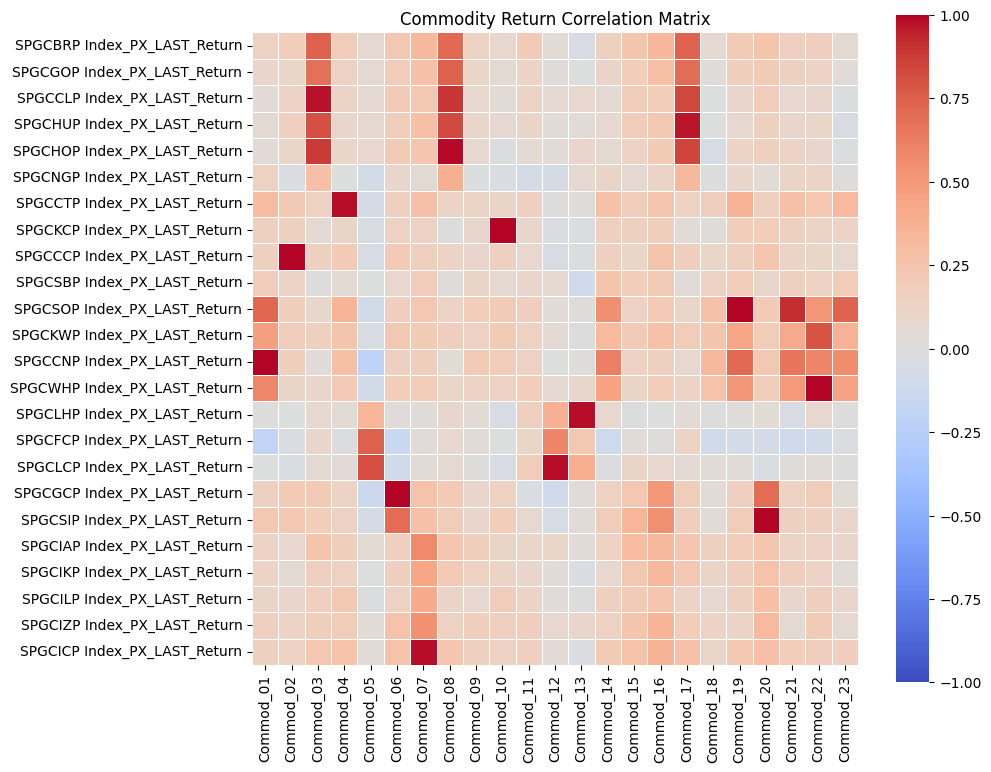

In [8]:
plt.figure(figsize=(10, 8))
corr_matrix_float1 = corr_matrix1.astype(float)
sns.heatmap(
    corr_matrix_float1,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.tight_layout()
plt.title("Commodity Return Correlation Matrix")
plt.show()

In [9]:
optimal_pairs_df1, row_ind, col_ind = decide_optimal_pairs(corr_matrix_float1)

In [10]:
ticker_to_commodity = {
    "SPGCBRP Index": "Crude Oil",
    "SPGCGOP Index": "Gasoil",
    "SPGCCLP Index": "WTI Crude",
    "SPGCHUP Index": "Unl. Gasoline",
    "SPGCHOP Index": "Heating Oil",
    "SPGCNGP Index": "Natural Gas",
    "SPGCCTP Index": "Cotton",
    "SPGCKCP Index": "Coffee",
    "SPGCCCP Index": "Cocoa",
    "SPGCSBP Index": "Sugar",
    "SPGCSOP Index": "Soybeans",
    "SPGCKWP Index": "Kansas Wheat",
    "SPGCCNP Index": "Corn",
    "SPGCWHP Index": "Wheat",
    "SPGCLHP Index": "Lean Hogs",
    "SPGCFCP Index": "Feeder Cattle",
    "SPGCLCP Index": "Live Cattle",
    "SPGCGCP Index": "Gold",
    "SPGCSIP Index": "Silver",
    "SPGCIAP Index": "Aluminum",
    "SPGCIKP Index": "Nickel",
    "SPGCILP Index": "Lead",
    "SPGCIZP Index": "Zinc",
    "SPGCICP Index": "Copper",
}

In [11]:
optimal_pairs_df1["GSCI Index"] = optimal_pairs_df1["Commodity_1"].str.replace(
    "_PX_LAST_Return", "", regex=False
)

# Map to real commodity names
optimal_pairs_df1["Commodity Name"] = optimal_pairs_df1["GSCI Index"].map(
    ticker_to_commodity
)
optimal_pairs_df1 = optimal_pairs_df1.rename(columns={"Commodity_2": "HKM Column Name"})

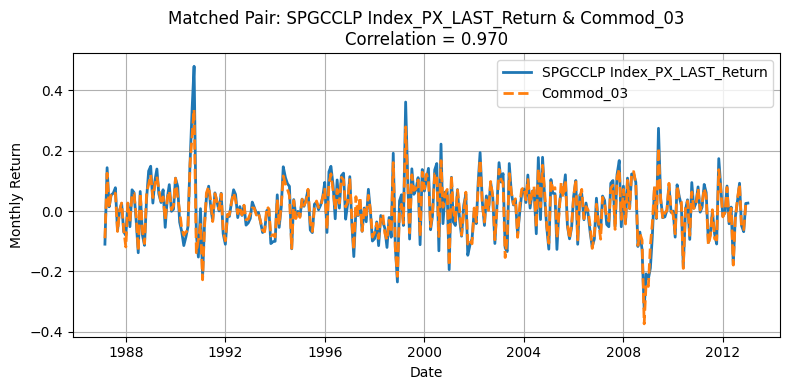

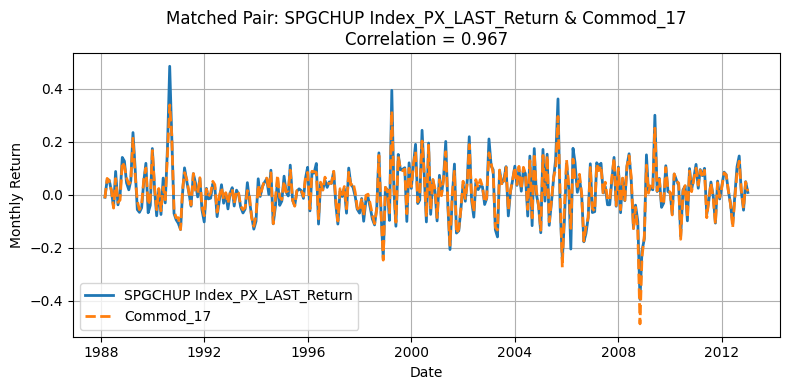

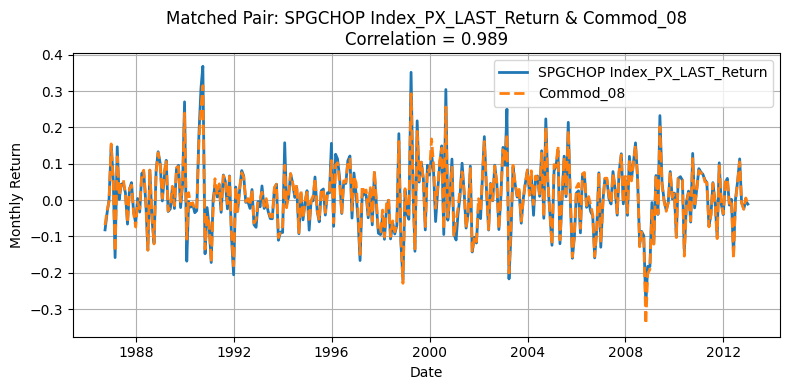

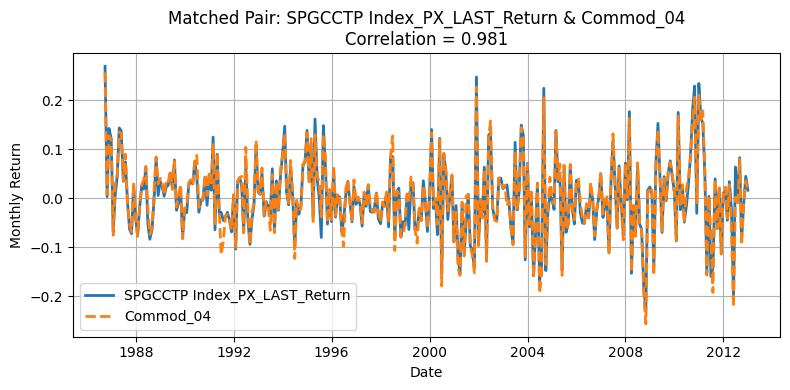

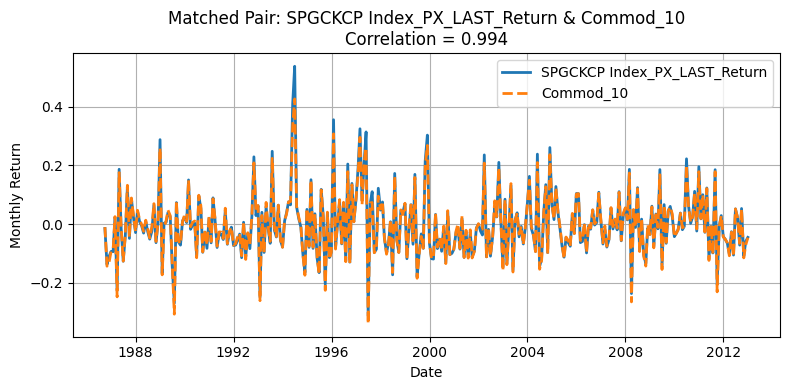

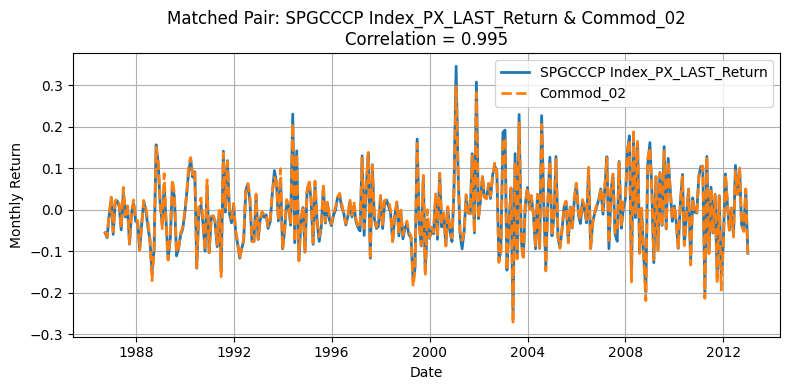

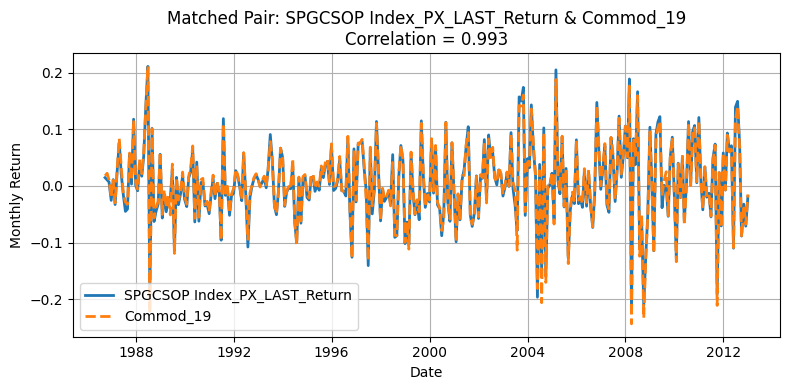

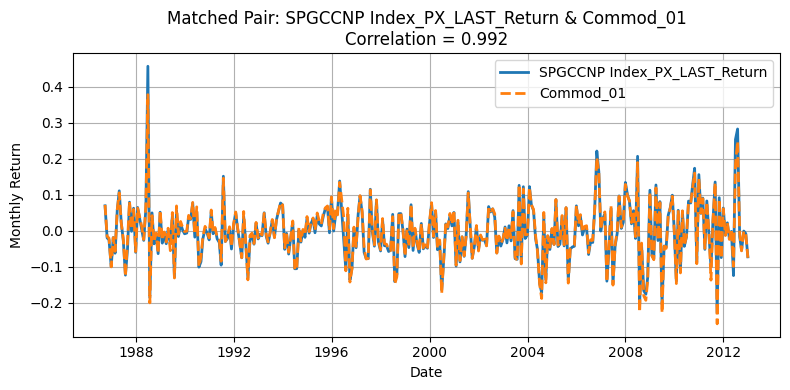

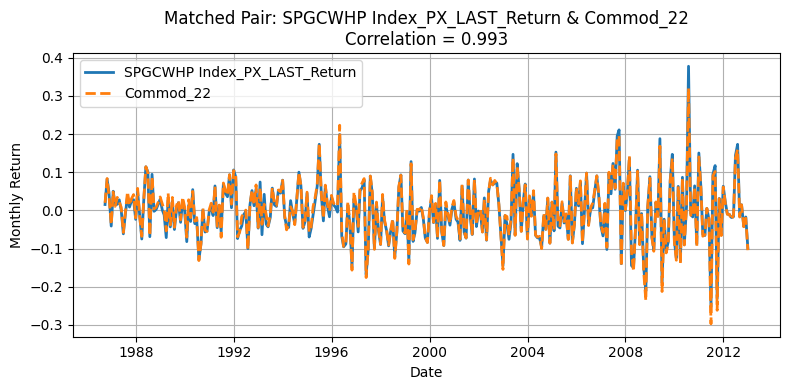

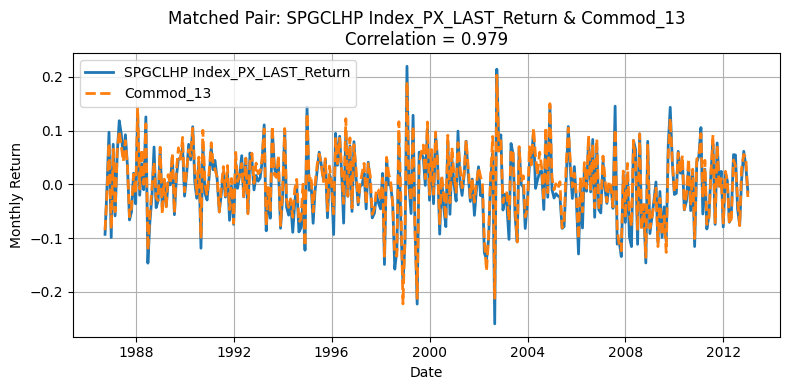

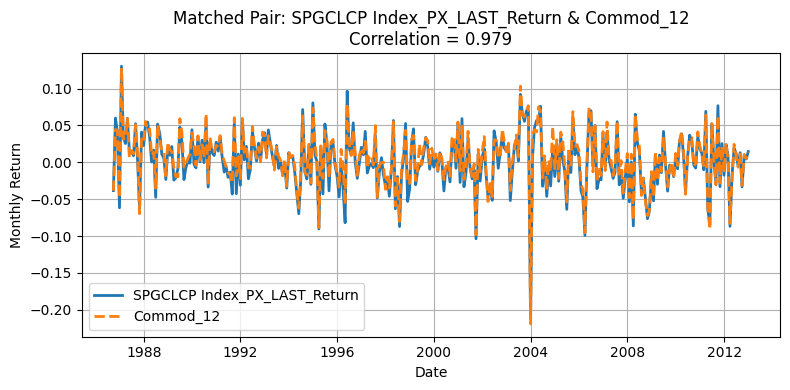

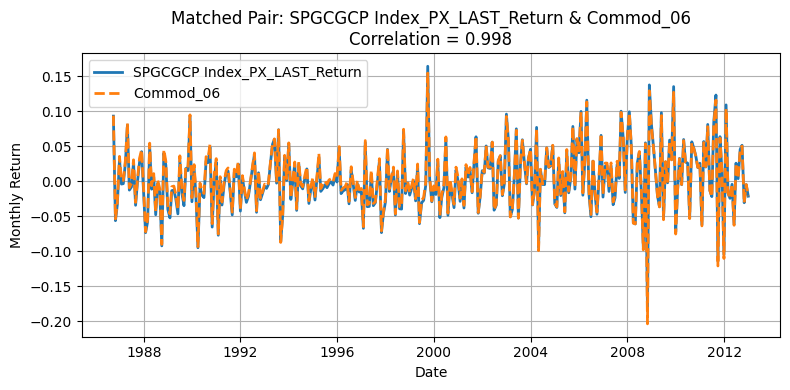

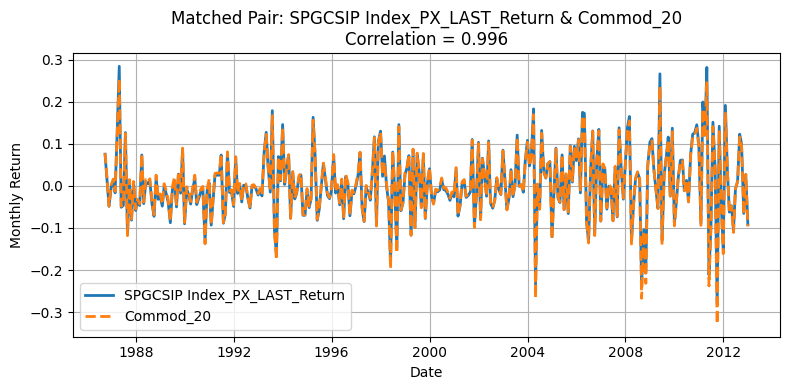

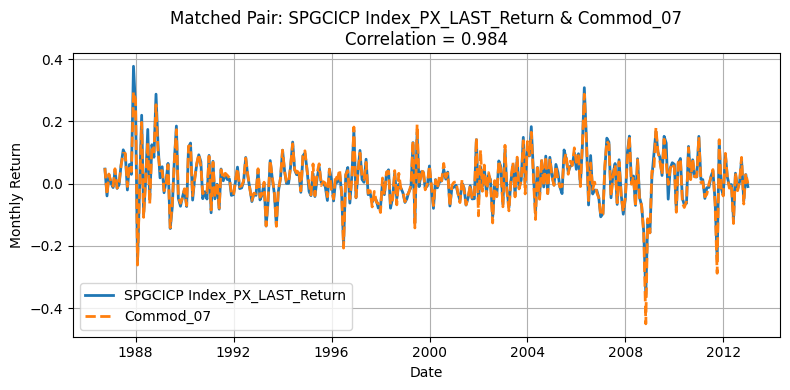

In [12]:
df1 = df_return1.copy()
df2 = hkm_df.copy()

for r, c in zip(row_ind, col_ind):
    corr_value = corr_matrix1.iloc[r, c]
    if corr_value < 0.85:
        continue  # Skip low correlation pairs

    commodity_1 = corr_matrix1.index[r]
    commodity_2 = corr_matrix1.columns[c]

    merged = (
        pd.DataFrame(
            {
                "Date": df1["Date"],
                f"d1_{commodity_1}": df1[commodity_1],
                f"d2_{commodity_2}": df2[commodity_2],
            }
        )
        .dropna()
        .set_index("Date")
    )

    plt.figure(figsize=(8, 4))
    plt.plot(
        merged.index, merged[f"d1_{commodity_1}"], label=f"{commodity_1}", linewidth=2
    )
    plt.plot(
        merged.index,
        merged[f"d2_{commodity_2}"],
        label=f"{commodity_2}",
        linewidth=2,
        linestyle="--",
    )

    plt.title(
        f"Matched Pair: {commodity_1} & {commodity_2}\nCorrelation = {corr_value:.3f}"
    )
    plt.xlabel("Date")
    plt.ylabel("Monthly Return")
    plt.legend()
    plt.grid(True)

    plt.xticks()
    plt.tight_layout()
    plt.show()

## Generate Standardized table 

In [13]:
list_of_return_ticker = optimal_pairs_df1["Commodity_1"].to_list()

In [14]:
def wide_to_long_returns(df, list_of_return_ticker):
    """
    Converts a wide-format return DataFrame to long-format with columns: ds, unique_id, y
    """

    if "yyyymm" in df.columns:
        id_col = "yyyymm"
    elif "Date" in df.columns:
        id_col = "Date"
    else:
        raise ValueError("No date column found!")

    cols = [id_col] + list_of_return_ticker
    df_sub = df[cols].copy()

    df_long = df_sub.melt(
        id_vars=id_col,
        value_vars=list_of_return_ticker,
        var_name="unique_id",
        value_name="y",
    )
    df_long = df_long.rename(columns={id_col: "ds"})

    df_long = df_long.dropna(subset=["y"])

    df_long = df_long.sort_values(["unique_id", "ds"]).reset_index(drop=True)

    return df_long[["unique_id", "ds", "y"]]

In [15]:
gsci_replication_df = wide_to_long_returns(df_return1, list_of_return_ticker)

In [16]:
gsci_replication_df.head(5)

,unique_id,ds,y
0,SPGCBRP Index_PX_LAST_Return,1999-02-26,-0.060203
1,SPGCBRP Index_PX_LAST_Return,1999-03-31,0.359040
2,SPGCBRP Index_PX_LAST_Return,1999-04-30,0.075051
3,SPGCBRP Index_PX_LAST_Return,1999-05-28,-0.057141
4,SPGCBRP Index_PX_LAST_Return,1999-06-30,0.132458


One source of deviation in our replication arises from differences in the underlying universe of commodities. The original HKM dataset selects 23 commodities from a broader pool of 31, whereas our replication process matches 23 out of 24 available contracts. Moreover, the two original pools themselves are not entirely overlapping, making mismatches almost inevitable. Commodities with correlations above 0.90 are likely those that overlap directly between the two datasets, while those with lower correlations often do not appear in the HKM table. Nevertheless, the strong alignment for major contracts supports the validity of using the GSCI index as an effective proxy for replicating the HKM methodology.

This interpretation is further supported by Yang’s table: although our replication remains an approximation—since HKM does not explicitly use GSCI data—we observe that the highly correlated tickers typically have at least 275 monthly observations in Yang’s datasets. This pattern suggests that these commodities were very likely included in the original HKM selection due to their long return histories.

## Alternative Approach 1
To closely follow the methodology of He, Kelly, and Manela (2017), we construct commodity return series based on constant one-month maturity futures prices. In their original approach, HKM derive such prices by linearly interpolating between the nearest, second-nearest, and third-nearest futures contracts. To approximate this, we use London Metal Exchange (LME) data where both cash and three-month futures prices are available, and compute a synthetic one-month price using a linear interpolation: $P_{1m} = P_{\text{cash}} + \frac{1}{3}(P_{3m} - P_{\text{cash}})$. This allows us to construct a monthly price series that mirrors the one-month maturity logic applied in HKM. For other commodities, we adopt the second-nearest (month-2) Bloomberg generic contracts (e.g., CO2 Comdty, NG2 Comdty) as a practical proxy for the interpolated price. Although this is a simplification, it maintains consistency with the spirit of HKM's approach and ensures comparability across commodities where interpolation is not feasible.


In [17]:
commodity_futures_df = load_futures_data.load_commodities_future(
    data_dir=DATA_DIR / "commodities"
)
lme_df = load_futures_data.load_lme_metals(data_dir=DATA_DIR / "commodities")

In [18]:
metal_map = {
    "Aluminum": ("LMAHDY Comdty_PX_LAST", "LMAHDS03 Comdty_PX_LAST"),
    "Nickel": ("LMNIDY Comdty_PX_LAST", "LMNIDS03 Comdty_PX_LAST"),
    "Lead": ("LMPBDY Comdty_PX_LAST", "LMPBDS03 Comdty_PX_LAST"),
    "Zinc": ("LMZSDY Comdty_PX_LAST", "LMZSDS03 Comdty_PX_LAST"),
    "Copper": ("LMCADY Comdty_PX_LAST", "LMCADS03 Comdty_PX_LAST"),
}

monthly_1mprice = calc_commodities_returns.calc_lme_monthly_1mprice(
    lme_df, metal_map, date_col="index"
)

lme_monthly_return = calc_commodities_returns.calc_lme_monthly_return(monthly_1mprice)

print(lme_monthly_return.head())

   yyyymm       Date  Aluminum    Nickel      Lead  Zinc    Copper
0  198709 1987-09-30  0.101317 -0.019891 -0.137613   NaN  0.073357
1  198710 1987-10-31 -0.058047  0.026383  0.016215   NaN  0.080608
2  198711 1987-11-30 -0.071148  0.073554  0.127458   NaN  0.378630
3  198712 1987-12-31  0.204262  0.350032  0.002539   NaN  0.113221
4  198801 1988-01-31 -0.036728 -0.042974  0.005976   NaN -0.249536


In [19]:
cmt_monthly_return = calc_commodities_returns.compute_second_contract_return(
    commodity_futures_df
)
cmt_monthly_return.head()

,yyyymm,Date,CO2 Comdty_PX_LAST,QS2 Comdty_PX_LAST,CL2 Comdty_PX_LAST,XB2 Comdty_PX_LAST,HO2 Comdty_PX_LAST,NG2 Comdty_PX_LAST,HU2 Comdty_PX_LAST,CT2 Comdty_PX_LAST,...,C 2 Comdty_PX_LAST,W 2 Comdty_PX_LAST,LH2 Comdty_PX_LAST,FC2 Comdty_PX_LAST,LC2 Comdty_PX_LAST,HG2 Comdty_PX_LAST,GC2 Comdty_PX_LAST,SI2 Comdty_PX_LAST,PA2 Comdty_PX_LAST,PL2 Comdty_PX_LAST
0,195907,1959-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195908,1959-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011952,...,-0.015385,0.005096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195909,1959-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003609,...,0.014509,0.018378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195910,1959-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005927,...,0.005501,0.016179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195911,1959-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011457,...,0.000000,-0.004287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
combined_df = pd.merge(
    cmt_monthly_return,
    lme_monthly_return.drop(columns=["Date"]),
    how="inner",
    on=["yyyymm"],
    suffixes=("", "_LME"),
).set_index("yyyymm")

In [21]:
common_idx = hkm_df.index.intersection(combined_df.index)

In [22]:
he_kelly_sub = hkm_df.loc[common_idx]
carry_sub = combined_df.loc[common_idx]

In [23]:
corr_matrix2 = generate_corr_matrix(he_kelly_sub, carry_sub.drop(columns=["Date"]))

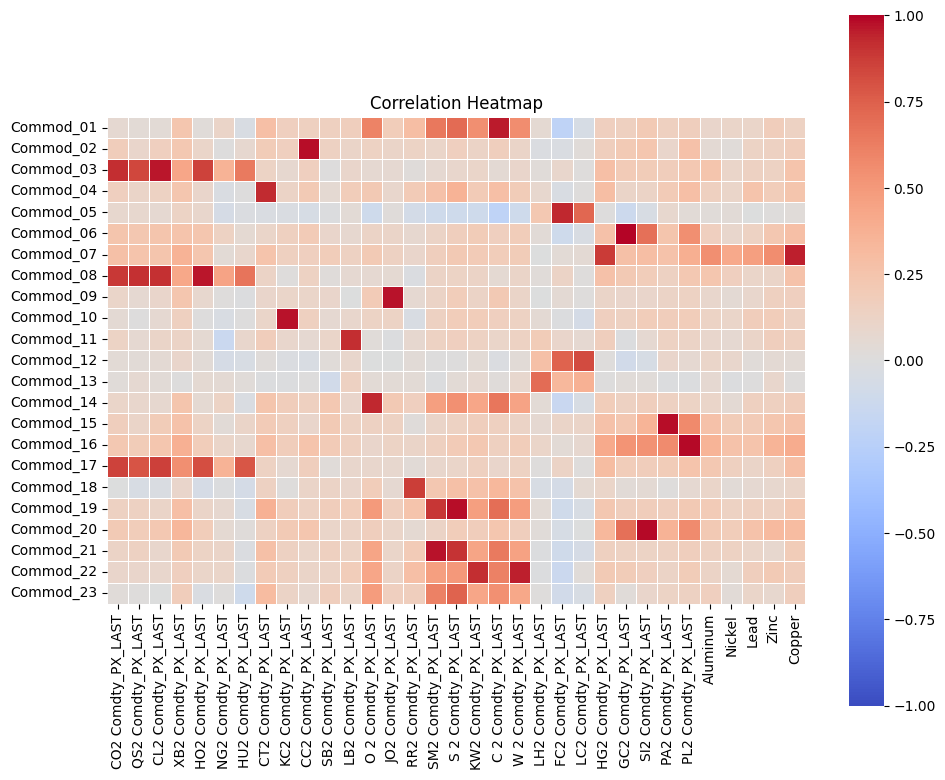

In [24]:
plt.figure(figsize=(10, 8))
corr_matrix_float2 = corr_matrix2.astype(float)
sns.heatmap(
    corr_matrix_float2,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [25]:
optimal_pairs_df2, row_ind, col_ind = decide_optimal_pairs(corr_matrix_float2)

In [26]:
ticker_to_commodity = {
    "CO2 Comdty_PX_LAST": "Crude Oil",
    "QS2 Comdty_PX_LAST": "Gasoil",
    "CL2 Comdty_PX_LAST": "WTI Crude",
    "XB2 Comdty_PX_LAST": "Unl. Gasoline",
    "HO2 Comdty_PX_LAST": "Heating Oil",
    "NG2 Comdty_PX_LAST": "Natural Gas",
    "CT2 Comdty_PX_LAST": "Cotton",
    "KC2 Comdty_PX_LAST": "Coffee",
    "CC2 Comdty_PX_LAST": "Cocoa",
    "SB2 Comdty_PX_LAST": "Sugar",
    "S 2 Comdty_PX_LAST": "Soybeans",
    "KW2 Comdty_PX_LAST": "Kansas Wheat",
    "C 2 Comdty_PX_LAST": "Corn",
    "W 2 Comdty_PX_LAST": "Wheat",
    "LH2 Comdty_PX_LAST": "Lean Hogs",
    "FC2 Comdty_PX_LAST": "Feeder Cattle",
    "LC2 Comdty_PX_LAST": "Live Cattle",
    "GC2 Comdty_PX_LAST": "Gold",
    "SI2 Comdty_PX_LAST": "Silver",
    "Aluminum": "Aluminum",
    "Nickel": "Nickel",
    "Lead": "Lead",
    "Zinc": "Zinc",
    "Copper": "Copper",
}


optimal_pairs_df2["Commodity_Name"] = optimal_pairs_df2["Commodity_2"].map(
    ticker_to_commodity
)

In [27]:
optimal_pairs_df2[["Commodity_Name", "Commodity_1", "Correlation"]]

,Commodity_Name,Commodity_1,Correlation
0,Gold,Commod_06,0.996136
1,Silver,Commod_20,0.990287
2,NaN,Commod_16,0.989176
3,Cocoa,Commod_02,0.983713
4,NaN,Commod_15,0.978422
5,Soybeans,Commod_19,0.976728
6,Coffee,Commod_10,0.971527
7,NaN,Commod_21,0.970256
8,NaN,Commod_09,0.969427
9,WTI Crude,Commod_03,0.961483


In [28]:
list_of_return_ticker = optimal_pairs_df2["Commodity_2"].to_list()

In [29]:
gsci_replication_df = wide_to_long_returns(combined_df, list_of_return_ticker)

In [30]:
gsci_replication_df.head(5)

,unique_id,ds,y
0,C 2 Comdty_PX_LAST,1987-09-30,0.130631
1,C 2 Comdty_PX_LAST,1987-10-31,-0.018592
2,C 2 Comdty_PX_LAST,1987-11-30,0.063599
3,C 2 Comdty_PX_LAST,1987-12-31,-0.026718
4,C 2 Comdty_PX_LAST,1988-01-31,0.058824


## Alternative Approach 2 -- Spot Commodities Futures
In this approach we use similar method as the previous approach but instead construct a “cash” return panel by combining two sources of prices. For precious metals, we use Bloomberg USD spot series obtained from `Curncy` tickers (XAUUSD, XAGUSD, XPTUSD, XPDUSD). For other commodities that lack a robust spot series in this module, we use a transparent proxy built from the first generic futures contract (`…1 Comdty`).




In [31]:
commodity_spot_df = pull_bbg_commodities_basis.load_commodity_spot_proxies(
    data_dir=DATA_DIR / "commodities"
)
precious_metal_spot_df = pull_bbg_commodities_basis.load_precious_metals_spot(
    data_dir=DATA_DIR / "commodities"
)
spot_df = commodity_spot_df.merge(precious_metal_spot_df, on="index")

In [32]:
spot_df.columns

Index(['index', 'CO1 Comdty_PX_LAST', 'QS1 Comdty_PX_LAST',
       'CL1 Comdty_PX_LAST', 'RB1 Comdty_PX_LAST', 'XB1 Comdty_PX_LAST',
       'HO1 Comdty_PX_LAST', 'NG1 Comdty_PX_LAST', 'HU1 Comdty_PX_LAST',
       'CT1 Comdty_PX_LAST', 'KC1 Comdty_PX_LAST', 'CC1 Comdty_PX_LAST',
       'SB1 Comdty_PX_LAST', 'LB1 Comdty_PX_LAST', 'O 1 Comdty_PX_LAST',
       'JO1 Comdty_PX_LAST', 'RR1 Comdty_PX_LAST', 'SM1 Comdty_PX_LAST',
       'WC1 Comdty_PX_LAST', 'S 1 Comdty_PX_LAST', 'KW1 Comdty_PX_LAST',
       'C 1 Comdty_PX_LAST', 'W 1 Comdty_PX_LAST', 'LH1 Comdty_PX_LAST',
       'FC1 Comdty_PX_LAST', 'LC1 Comdty_PX_LAST', 'AL1 Comdty_PX_LAST',
       'HG1 Comdty_PX_LAST', 'GC1 Comdty_PX_LAST', 'SI1 Comdty_PX_LAST',
       'PA1 Comdty_PX_LAST', 'PL1 Comdty_PX_LAST', 'XAUUSD Curncy_PX_LAST',
       'XAGUSD Curncy_PX_LAST', 'XPTUSD Curncy_PX_LAST',
       'XPDUSD Curncy_PX_LAST'],
      dtype='object')

In [33]:
monthly_return = calc_commodities_returns.monthly_returns_mixed_prices(spot_df)

/Users/jbejarano/GitRepositories/ftsfr/src/commodities/calc_commodities_returns.py:322: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = monthly_px.pct_change()


In [34]:
common_idx = hkm_df.index.intersection(monthly_return.index)

In [35]:
he_kelly_sub = hkm_df.loc[common_idx]
carry_sub = monthly_return.loc[common_idx]

In [36]:
corr_matrix3 = generate_corr_matrix(he_kelly_sub, carry_sub.drop(columns=["Date"]))

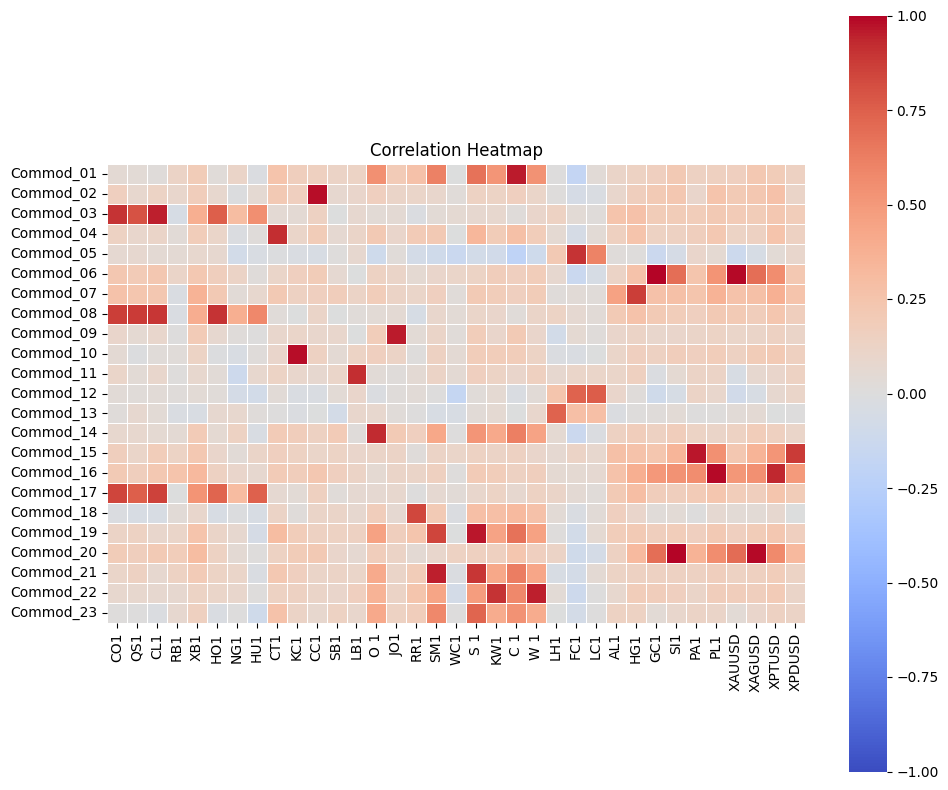

In [37]:
plt.figure(figsize=(10, 8))
corr_matrix_float3 = corr_matrix3.astype(float)
sns.heatmap(
    corr_matrix_float3,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [38]:
optimal_pairs_df3, row_ind, col_ind = decide_optimal_pairs(corr_matrix_float3)

In [39]:
ticker_to_name = {
    "GC1": "Gold",
    "SI1": "Silver",
    "PL1": "Platinum",
    "CC1": "Cocoa",
    "KC1": "Coffee",
    "S 1": "Soybeans",
    "PA1": "Palladium",
    "JO1": "Orange Juice",
    "C 1": "Corn",
    "CL1": "WTI Crude Oil",
    "SM1": "Soybean Meal",
    "W 1": "Wheat (SRW)",
    "O 1": "Oats",
    "CT1": "Cotton",
    "LB1": "Lumber",
    "HO1": "Heating Oil",
    "FC1": "Feeder Cattle",
    "HG1": "Copper",
    "CO1": "Brent Crude Oil",
    "RR1": "Rough Rice",
    "LC1": "Live Cattle",
    "LH1": "Lean Hogs",
    "KW1": "Kansas Wheat (HRW)",
}
optimal_pairs_df3["Commodity_Name"] = optimal_pairs_df3["Commodity_2"].map(
    ticker_to_name
)

In [40]:
optimal_pairs_df3

,Commodity_1,Commodity_2,Correlation,Commodity_Name
0,Commod_06,GC1,0.995406,Gold
1,Commod_20,SI1,0.994950,Silver
2,Commod_16,PL1,0.989246,Platinum
3,Commod_02,CC1,0.981584,Cocoa
4,Commod_10,KC1,0.977102,Coffee
5,Commod_19,S 1,0.964628,Soybeans
6,Commod_15,PA1,0.961944,Palladium
7,Commod_09,JO1,0.953366,Orange Juice
8,Commod_01,C 1,0.953333,Corn
9,Commod_03,CL1,0.952918,WTI Crude Oil
